In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
from sklearn.metrics import classification_report

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers import Embedding, Dense, Lambda
from keras.regularizers import l2

from keras.utils import to_categorical

Using TensorFlow backend.


#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_score 
from src.load_data import load_data

### Load Data

In [7]:
n_tags = 2

In [8]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [9]:
def get_contextual_sentences(data_, ww):

    X = []
    for article in data_:
        sent_list = article['sentences']
        for i, sentence in enumerate(sent_list):
            merged_sents = [sent_list[0]['sentence'].replace('\n', '').strip()]
            for w in range(1, ww):
                if i - w >= 0:
                    merged_sents = [sent_list[i-w]['sentence'].replace('\n', '').strip()] + merged_sents
                if i + w < len(sent_list):
                    merged_sents.append(sent_list[i+w]['sentence'].replace('\n', '').strip())
            X.append(' '.join(merged_sents))

    return np.array(X)

In [10]:
def get_y(data_, to_categorize):

    y = np.array([sentence['label'] for article in data_ for sentence in article['sentences']])
    if to_categorize:
        y = to_categorical(y)
    
    return y

In [11]:
# sliding window width
ww = 1

In [12]:
X_tra = get_contextual_sentences(train_data, ww)
X_val = get_contextual_sentences(valid_data, ww)
X_test = get_contextual_sentences(test_data, ww)

In [13]:
y_tra = get_y(train_data, True)
y_val = get_y(valid_data, True)
y_test = get_y(test_data, False)

### Load ELMo

In [14]:
sess = tf.Session()
K.set_session(sess)

In [15]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Flat Model

In [16]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [17]:
def build_flat_model_3():
    
    input_text = Input(shape=(1,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    
    pred = Dense(2, activation='sigmoid')(dense)
    
    return Model(inputs=[input_text], outputs=pred)

In [18]:
model_name = 'RQ1_elmo_flat_model_1_contextual'
model = build_flat_model_3()
model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])

W0828 15:09:24.230224 140301290213504 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 15:09:24.231431 140301290213504 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 15:09:24.481408 140301290213504 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 15:09:24.558816 140301290213504 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: T

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 656,642
Trainable params: 656,642
Non-trainable params: 0
_________________________________________________________________


### Train

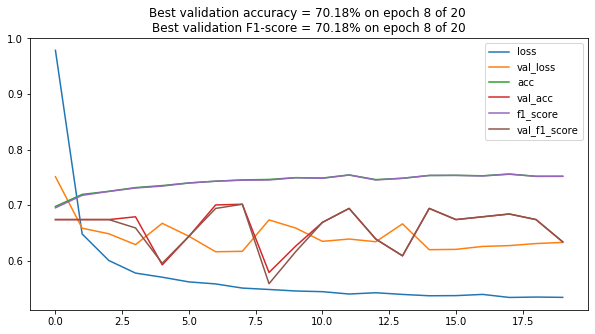

In [19]:
## Flat Model Fit ww=1
model.fit(X_tra, y_tra, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name=model_name)])

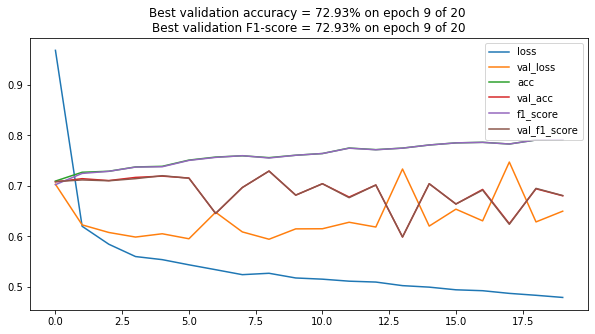

In [19]:
## Flat Model Fit ww=2
model.fit(X_tra, y_tra, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name=model_name)])

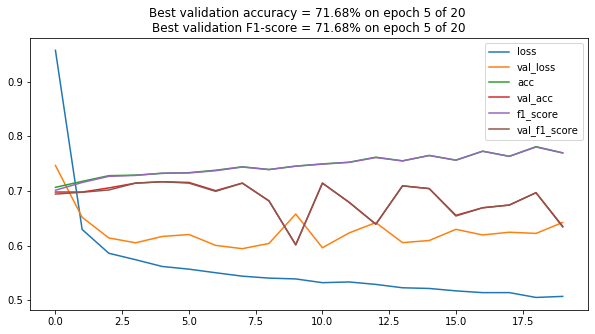

In [32]:
## Flat Model Fit ww=5
model.fit(X_tra, y_tra, epochs=20, batch_size=32, validation_data=(X_val, y_val), 
          callbacks=[PlotCurves(model_name=model_name)])

### Test

from keras.models import load_model
#Returns a compiled model identical to the previous one
model = load_model('./Model/RQ1_elmo_flat_model_1_contextual/RQ1_elmo_flat_model_1_contextual_epoch_9.h5')

In [20]:
y_preds = model.predict(X_test, batch_size=32)

In [21]:
y_preds = np.argmax(y_preds, axis=1)

In [22]:
### build_flat_model_1 results ww=1
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.75      0.97      0.84       325
           1       0.47      0.08      0.13       116

   micro avg       0.73      0.73      0.73       441
   macro avg       0.61      0.52      0.49       441
weighted avg       0.67      0.73      0.66       441



In [22]:
### build_flat_model_1 results ww=2
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       325
           1       0.53      0.42      0.47       116

   micro avg       0.75      0.75      0.75       441
   macro avg       0.67      0.65      0.65       441
weighted avg       0.74      0.75      0.74       441



In [35]:
### build_flat_model_1 results ww=5
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.77      0.85      0.81       325
           1       0.40      0.28      0.33       116

   micro avg       0.70      0.70      0.70       441
   macro avg       0.58      0.57      0.57       441
weighted avg       0.67      0.70      0.68       441

